 # 图像的分类与定位

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from lxml import etree
from matplotlib.patches import Rectangle
import numpy as np
import glob

tf.__version__

'2.0.0'

## 数据集示例

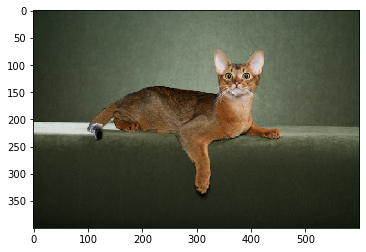

In [2]:
# 读取图片
img = tf.io.read_file("dataset/Oxford_IIIT/images/Abyssinian_1.jpg")
img = tf.image.decode_jpeg(img)
plt.imshow(img)

In [3]:
# 解析边框
with  open('dataset/Oxford_IIIT/annotations/xmls/Abyssinian_1.xml') as f:
    xml = f.read()
# 解析xml文件
sel = etree.HTML(xml)
# 得到宽高和坐标
width = int(sel.xpath('//size/width/text()')[0])
height = int(sel.xpath('//size/height/text()')[0])
xmin = int(sel.xpath('//bndbox/xmin/text()')[0])
ymin = int(sel.xpath('//bndbox/ymin/text()')[0])
xmax = int(sel.xpath('//bndbox/xmax/text()')[0])
ymax = int(sel.xpath('//bndbox/ymax/text()')[0])
print("width: ", width)
print("height: ", height)
print("xmin: ", xmin)
print("ymin: ", ymin)
print("xmax: ", xmax)
print("ymax: ", ymax)

width:  600
height:  400
xmin:  333
ymin:  72
xmax:  425
ymax:  158


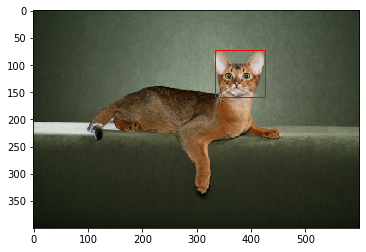

In [4]:
# 显示图片和边框
plt.imshow(img)
# Rectangle参数
# 第一个参数为图片左下角的坐标
# 第二个参数为图片的宽度
# 第三个参数为图片的高度
# fill代表是否填充
rect = Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), fill=False, color='red')
# 画框
plt.gca().add_patch(rect)
plt.show()

In [5]:
# 标签坐标的处理  
# 因为图像的坐标是相对于图片大小而言的，图片的大小又不一样，所以需要将坐标转为比例坐标
img = tf.image.resize(img, [224, 224])
img = img / 255
# 坐标缩放
xmin = xmin / width * 224
ymin = ymin / height * 224
xmax = xmax / width * 224
ymax = ymax / height * 224

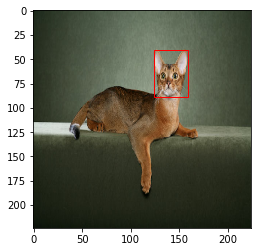

In [6]:
# 显示图片和边框
plt.imshow(img)
# Rectangle参数
# 第一个参数为图片左下角的坐标
# 第二个参数为图片的宽度
# 第三个参数为图片的高度
# fill代表是否填充
rect = Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), fill=False, color='red')
# 画框
plt.gca().add_patch(rect)
plt.show()

## 创建输入dataset

In [7]:
image_path = glob.glob("dataset/Oxford_IIIT/images/*.jpg")
image_path[:5]

['dataset/Oxford_IIIT/images\\Abyssinian_1.jpg',
 'dataset/Oxford_IIIT/images\\Abyssinian_10.jpg',
 'dataset/Oxford_IIIT/images\\Abyssinian_100.jpg',
 'dataset/Oxford_IIIT/images\\Abyssinian_101.jpg',
 'dataset/Oxford_IIIT/images\\Abyssinian_102.jpg']

In [8]:
xml_path = glob.glob("dataset/Oxford_IIIT/annotations/xmls/*.xml")
xml_path[:5]

['dataset/Oxford_IIIT/annotations/xmls\\Abyssinian_1.xml',
 'dataset/Oxford_IIIT/annotations/xmls\\Abyssinian_10.xml',
 'dataset/Oxford_IIIT/annotations/xmls\\Abyssinian_100.xml',
 'dataset/Oxford_IIIT/annotations/xmls\\Abyssinian_101.xml',
 'dataset/Oxford_IIIT/annotations/xmls\\Abyssinian_102.xml']

In [9]:
len(image_path), len(xml_path)

(7390, 3686)

#### 因为不是所有图片都有标签所以将有标签的图片作为训练集，没有标签的图片作为测试集

In [10]:
# 截取xml的名字部分
xml_path[0].split('\\')[1].split('.')[0]

'Abyssinian_1'

In [11]:
xml_name = [path.split('\\')[1].split('.')[0] for path in xml_path]

In [12]:
# 将有标签的图片作为训练集，没有标签的图片作为测试集
train_image_path = [path for path in image_path if path.split('\\')[1].split('.')[0] in xml_name]
test_image_path = [path for path in image_path if path not in train_image_path]
len(train_image_path)

3686

In [13]:
# 将图片路径按照名字进行排序，保证图片和标签一一对应
train_image_path.sort(key=lambda x: x.split('\\')[1].split('.')[0])
train_image_path[:5]

['dataset/Oxford_IIIT/images\\Abyssinian_1.jpg',
 'dataset/Oxford_IIIT/images\\Abyssinian_10.jpg',
 'dataset/Oxford_IIIT/images\\Abyssinian_100.jpg',
 'dataset/Oxford_IIIT/images\\Abyssinian_101.jpg',
 'dataset/Oxford_IIIT/images\\Abyssinian_102.jpg']

In [14]:
def load_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = img / 255.0
    return img

In [15]:
# 创建训练集的dataset
train_image_dataset = tf.data.Dataset.from_tensor_slices(train_image_path)
train_image_dataset = train_image_dataset.map(load_image)
train_image_dataset

<MapDataset shapes: (224, 224, 3), types: tf.float32>

In [16]:
# 创建测试集的dataset
test_image_dataset = tf.data.Dataset.from_tensor_slices(test_image_path)
test_image_dataset = test_image_dataset.map(load_image)
test_image_dataset

<MapDataset shapes: (224, 224, 3), types: tf.float32>

#### 创建标签的dataset

In [17]:
# 将标签路径按照名字进行排序，保证图片和标签一一对应
xml_path.sort(key=lambda x: x.split('\\')[1].split('.')[0])
xml_path[:5]

['dataset/Oxford_IIIT/annotations/xmls\\Abyssinian_1.xml',
 'dataset/Oxford_IIIT/annotations/xmls\\Abyssinian_10.xml',
 'dataset/Oxford_IIIT/annotations/xmls\\Abyssinian_100.xml',
 'dataset/Oxford_IIIT/annotations/xmls\\Abyssinian_101.xml',
 'dataset/Oxford_IIIT/annotations/xmls\\Abyssinian_102.xml']

In [18]:
# 解析xml为label
def xml_to_label(path):
    with  open(path) as f:
        xml = f.read()
    # 解析xml文件
    sel = etree.HTML(xml)
    # 得到种类
    name = sel.xpath('//object/name/text()')[0]
    # 得到宽高和坐标
    width = int(sel.xpath('//size/width/text()')[0])
    height = int(sel.xpath('//size/height/text()')[0])
    xmin = int(sel.xpath('//bndbox/xmin/text()')[0])
    ymin = int(sel.xpath('//bndbox/ymin/text()')[0])
    xmax = int(sel.xpath('//bndbox/xmax/text()')[0])
    ymax = int(sel.xpath('//bndbox/ymax/text()')[0])
    return name, [xmin/width, ymin/height, xmax/width, ymax/height]

names = [xml_to_label(path)[0] for path in xml_path]
labels = [xml_to_label(path)[1] for path in xml_path]
names[0], labels[0]

('cat', [0.555, 0.18, 0.7083333333333334, 0.395])

In [19]:
name_to_index = dict((name, index) for index, name in enumerate(set(names)))
index_to_name = dict((index, name) for index, name in enumerate(set(names)))
name_to_index, index_to_name

({'cat': 0, 'dog': 1}, {0: 'cat', 1: 'dog'})

In [20]:
name_label = [name_to_index[name] for name in names]
name_label[:5]

[0, 0, 0, 0, 0]

In [21]:
xmin_label, ymin_label, xmax_label, ymax_label = zip(*labels)

In [22]:
xmin_label[0], ymin_label[0], xmax_label[0], ymax_label[0]

(0.555, 0.18, 0.7083333333333334, 0.395)

In [23]:
xmin_label = list(xmin_label)
ymin_label = list(ymin_label)
xmax_label = list(xmax_label)
ymax_label = list(ymax_label)
label_dataset = tf.data.Dataset.from_tensor_slices((xmin_label, ymin_label, xmax_label, ymax_label, name_label))
label_dataset

<TensorSliceDataset shapes: ((), (), (), (), ()), types: (tf.float32, tf.float32, tf.float32, tf.float32, tf.int32)>

In [24]:
dataset = tf.data.Dataset.zip((train_image_dataset, label_dataset))
train_num = len(train_image_path)
BATCH_SIZE = 16
dataset = dataset.shuffle(train_num).repeat().batch(BATCH_SIZE)
dataset

<BatchDataset shapes: ((None, 224, 224, 3), ((None,), (None,), (None,), (None,), (None,))), types: (tf.float32, (tf.float32, tf.float32, tf.float32, tf.float32, tf.int32))>

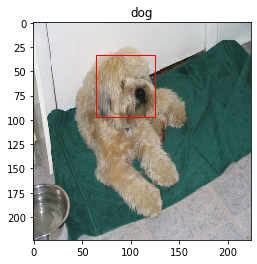

In [25]:
# datase样例
# 得到一个batch数据
for imgs, labels in dataset.take(1):
    plt.imshow(imgs[0])
    xmin, ymin, xmax, ymax, index = labels[0][0]*224, labels[1][0]*224, labels[2][0]*224, labels[3][0]*224, labels[4][0]
    xmin, ymin, xmax, ymax = xmin.numpy(), ymin.numpy(), xmax.numpy(), ymax.numpy()
    plt.title(index_to_name[index.numpy()])
    rect = Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), fill=False, color='red')
    plt.gca().add_patch(rect)
    plt.show()

## 构建模型

In [26]:
base_model = tf.keras.applications.Xception(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [27]:
# 取最后一层的输出
x = base_model.output
# 坐标值的全连接层
x1 = tf.keras.layers.Dense(2048, activation='relu')(x)
x1 = tf.keras.layers.Dense(256, activation='relu')(x1)
# xmin
xmin_out = tf.keras.layers.Dense(1, name="xmin")(x1)
# ymin
ymin_out = tf.keras.layers.Dense(1, name="ymin")(x1)
# xmax
xmax_out = tf.keras.layers.Dense(1, name="xmax")(x1)
# ymax
ymax_out = tf.keras.layers.Dense(1, name="ymax")(x1)
# 分类的全连接层
x2 = tf.keras.layers.Dense(1024, activation='relu')(x)
index_out = tf.keras.layers.Dense(1, activation='sigmoid', name="index")(x2)

out = [xmin_out, ymin_out, xmax_out, ymax_out, index_out]
model = tf.keras.models.Model(base_model.input, out)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [28]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss = {"xmin":"mse", 
                      "xmax":"mse",
                      "ymin":"mse",
                      "ymax":"mse",
                      "index":"binary_crossentropy"},
              metrics = {"xmin":"mae", 
                         "xmax":"mae",
                         "ymin":"mae",
                         "ymax":"mae",
                         "index":"accuracy"})

In [29]:
train = model.fit(dataset,
                  epochs = 50,
                  steps_per_epoch = train_num // BATCH_SIZE)

Train for 230 steps
Epoch 1/50
230/230 [==============================] - 156s 678ms/step - loss: 0.1768 - xmin_loss: 0.0210 - ymin_loss: 0.0133 - xmax_loss: 0.0271 - ymax_loss: 0.0244 - index_loss: 0.0910 - xmin_mae: 0.1123 - ymin_mae: 0.0874 - xmax_mae: 0.1242 - ymax_mae: 0.1175 - index_accuracy: 0.9674
Epoch 2/50
230/230 [==============================] - 148s 642ms/step - loss: 0.0520 - xmin_loss: 0.0084 - ymin_loss: 0.0061 - xmax_loss: 0.0105 - ymax_loss: 0.0101 - index_loss: 0.0168 - xmin_mae: 0.0721 - ymin_mae: 0.0610 - xmax_mae: 0.0812 - ymax_mae: 0.0799 - index_accuracy: 0.9943
Epoch 3/50
230/230 [==============================] - 148s 645ms/step - loss: 0.0455 - xmin_loss: 0.0059 - ymin_loss: 0.0041 - xmax_loss: 0.0078 - ymax_loss: 0.0072 - index_loss: 0.0204 - xmin_mae: 0.0603 - ymin_mae: 0.0496 - xmax_mae: 0.0696 - ymax_mae: 0.0670 - index_accuracy: 0.9948
Epoch 4/50
230/230 [==============================] - 148s 645ms/step - loss: 0.0280 - xmin_loss: 0.0053 - ymin_loss: 0

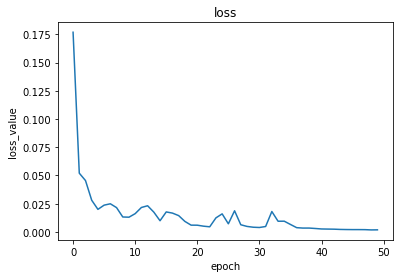

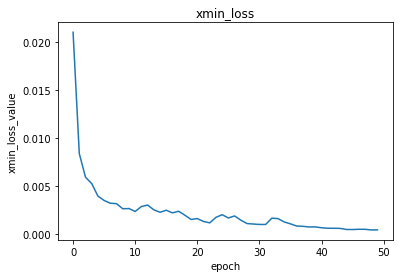

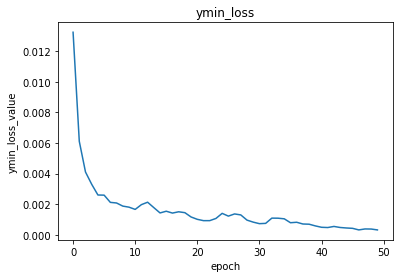

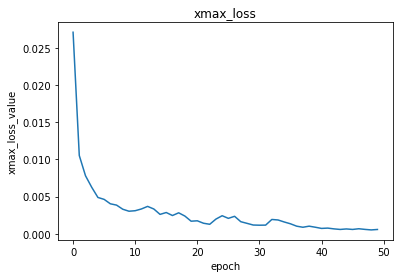

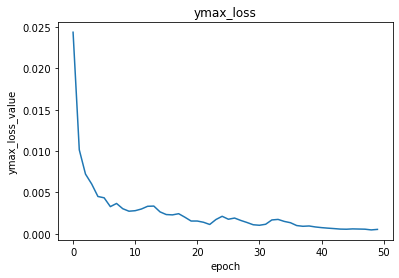

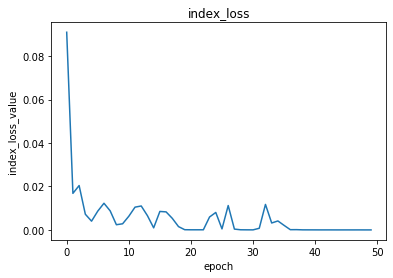

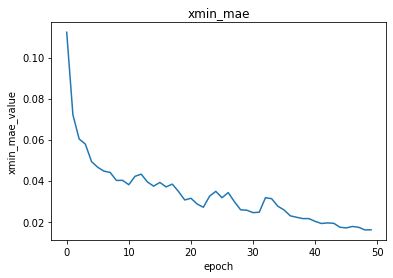

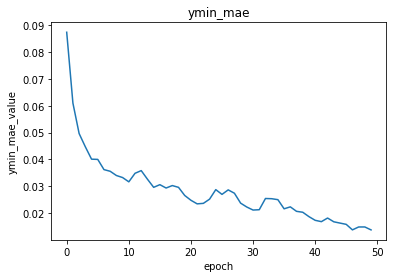

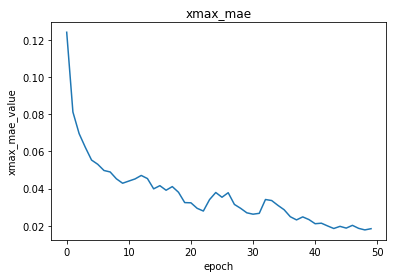

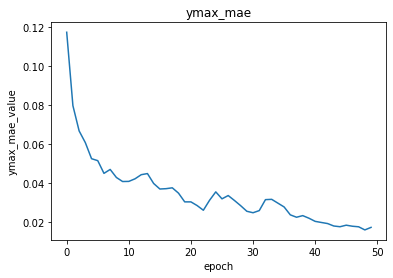

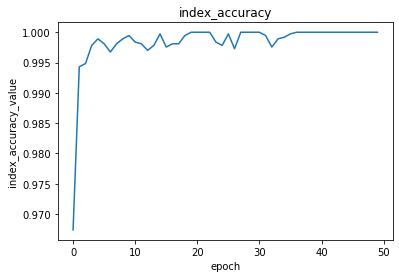

In [30]:
for key, value in train.history.items():
    plt.title(key)
    plt.plot(train.epoch, value)
    plt.xlabel("epoch")
    plt.ylabel(key+'_value')
    plt.show()

# 用模型对测试集进行预测

预测结果：
[[0.17750409]] [[0.05044641]] [[0.8360352]] [[0.9022093]] [[0.9999994]]


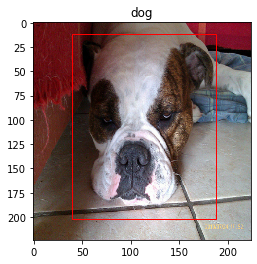

预测结果：
[[0.41549596]] [[0.15489016]] [[0.90656215]] [[0.49354962]] [[1.]]


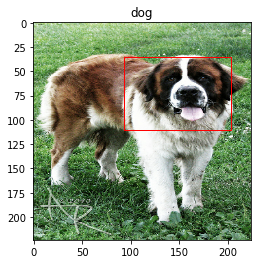

预测结果：
[[0.5079261]] [[0.08598403]] [[0.76547784]] [[0.4125529]] [[1.]]


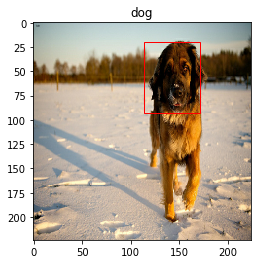

In [31]:
for image in test_image_dataset.shuffle(len(image_path)-train_num).take(3):
    plt.imshow(image)
    # 预测结果为ndarry
    xmins, ymins, xmaxs, ymaxs, indexs = model.predict(tf.expand_dims(image, axis=0))
    print("预测结果：")
    print(xmins, ymins, xmaxs, ymaxs, indexs)
    
    xmin, ymin, xmax, ymax = xmins[0][0]*224, ymins[0][0]*224, xmaxs[0][0]*224, ymaxs[0][0]*224
    index = int(indexs[0][0] > 0.5)
    plt.title(index_to_name[index])
    rect = Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), fill=False, color='red')
    plt.gca().add_patch(rect)
    plt.show()